# Notebook for training and testing Graph Neural Network for Neural Collaborative Filtering


In [23]:
from torch_geometric.data import DataLoader
from gncf import GNCF
from graph_epinions_dataset import GraphEpinionsDataset
from epinions_graph import *
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import tensorflow as tf

ImportError: cannot import name 'struct_pb2' from 'google.protobuf' (/Users/Robert/.local/lib/python3.11/site-packages/google/protobuf/__init__.py)

In [10]:
# Set device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# Load train data to determine train/test split
train_data = pd.read_csv('data/train.csv')
train_idx = len(train_data)

# Return node features and mapping from user/item to index
_, user_mapping = load_node_csv('data/all_data.csv', index_col='user')
_, item_mapping = load_node_csv('data/all_data.csv', index_col='item')

# Return edge index and edge attributes
edge_index, edge_label = load_edge_csv('data/all_data.csv', 
                                      src_index_col='user', 
                                      src_mapping=user_mapping, 
                                      dst_index_col='item', 
                                      dst_mapping=item_mapping,
                                      encoders={'label': IdentityEncoder(dtype=torch.long)})
    

data = HeteroData()
data['user'].x = torch.arange(len(user_mapping))
data['item'].x = torch.arange(len(item_mapping))
data['user', 'rates', 'item'].edge_index = edge_index
data['user', 'rates', 'item'].edge_label = edge_label

train_data = data.clone()
test_data = data.clone()

# Partition in training and test set
train_data['user', 'rates','item'].edge_index = data['user', 'rates', 'item'].edge_index[:, :train_idx]
train_data['user', 'rates','item'].edge_label = data['user', 'rates', 'item'].edge_label[:train_idx]
train_data['user', 'rates', 'item'].edge_label_index = data['user', 'rates', 'item'].edge_index[:, :train_idx]

test_data['user', 'rates','item'].edge_index = data['user', 'rates', 'item'].edge_index[:, :train_idx]
test_data['user', 'rates','item'].edge_label = data['user', 'rates', 'item'].edge_label[train_idx:]
test_data['user', 'rates', 'item'].edge_label_index = data['user', 'rates', 'item'].edge_index[:, train_idx:]

# Add a reverse edge for user aggregration/item modeling
train_data = ToUndirected()(train_data)
del train_data['item', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.
test_data = ToUndirected()(test_data)
del test_data['item', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

num_users = len(user_mapping)
num_items = len(item_mapping)

# Add negtive sampling for test data
neg_edge_list = []
for user in range(num_users):
    negative_samples = set()
    user_neighbors = edge_index[1, edge_index[0] == user]
    while len(negative_samples) < 100:
        neg_item = torch.randint(0, num_items, (1,)).item()
        if neg_item not in user_neighbors:
            negative_samples.add(neg_item)

    neg_edges = torch.tensor([[user] * 100, list(negative_samples)])
    neg_edge_list.append(neg_edges)

neg_edge_label_index = torch.cat(neg_edge_list, dim=1)
test_data['user', 'rates', 'item'].neg_edge_label = torch.zeros(neg_edge_label_index.size(1)).unsqueeze(1)
test_data['user', 'rates', 'item'].neg_edge_label_index = neg_edge_label_index

# train_data = train_data.to(device)
# test_data = test_data.to(device)

print(train_data)
print(test_data)  

HeteroData(
  user={ x=[1178] },
  item={ x=[15094] },
  (user, rates, item)={
    edge_index=[2, 94530],
    edge_label=[94530, 1],
    edge_label_index=[2, 94530],
  },
  (item, rev_rates, user)={ edge_index=[2, 94530] }
)
HeteroData(
  user={ x=[1178] },
  item={ x=[15094] },
  (user, rates, item)={
    edge_index=[2, 94530],
    edge_label=[1178, 1],
    edge_label_index=[2, 1178],
    neg_edge_label=[117800, 1],
    neg_edge_label_index=[2, 117800],
  },
  (item, rev_rates, user)={ edge_index=[2, 94530] }
)


In [11]:
def test(model, data, criterion, topk=10):
    model.eval()
    num_pos = len(data['user', 'item'].edge_label)
    pos_pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'item'].edge_label_index)
    neg_pred = model(data.x_dict, data.edge_index_dict,
                     data['user', 'item'].neg_edge_label_index)
    pos_target = data['user', 'item'].edge_label.float()
    neg_target = data['user', 'item'].neg_edge_label.float()
    preds = torch.cat([pos_pred, neg_pred], dim=0)
    targets = torch.cat([pos_target, neg_target], dim=0)
    test_loss = criterion(preds, targets)
    
    neg_pred = neg_pred.reshape(num_pos, -1)
    preds = torch.cat([pos_pred, neg_pred], dim=1)
    _, indices = torch.topk(-preds, topk, dim=1)
    num_hits = torch.sum(indices == 0).item()

    return num_hits / num_pos, test_loss.item()

In [27]:
def train(model, optimizer, criterion, save_path, epochs=10):
    writer = tf.summary.create_file_writer(f'runs/{save_path}')
    model.train()
    hit_ratios = []
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                    train_data['user', 'item'].edge_label_index)
        target = (train_data['user', 'item'].edge_label).float()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        hit_ratio, test_loss = test(model, test_data, criterion, topk=10)
        hit_ratios.append(hit_ratio)
        test_losses.append(test_loss)

        with writer.as_default():
            tf.summary.scalar('Loss/train', loss.item(), step=epoch+1)
            tf.summary.scalar('Loss/test', test_loss, step=epoch+1)
            tf.summary.scalar('Hit Ratio', hit_ratio, step=epoch+1)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs} Loss {loss.item()}, Hit Ratio {hit_ratio}, Test Loss {test_loss}')

    return train_losses, hit_ratios, test_losses

In [28]:
# Define model parameters
num_users = len(user_mapping)
num_items = len(item_mapping)
user_emb_dim = 128
item_emb_dim = 128
hidden_channels = 32
out_channels = 16
epochs = 5
lr = 0.01
metadata = train_data.metadata()
save_path = f'gncf_user_emb_dim-{user_emb_dim}_item_emb_dim-{item_emb_dim}_hidden_channels-{hidden_channels}_out_channels-{out_channels}_epochs-{epochs}_lr-{lr}'

# Create model
model = GNCF(num_users, num_items, user_emb_dim, item_emb_dim, hidden_channels, out_channels, metadata)
# model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [29]:
train_losses, hit_ratios, test_losses = train(model, optimizer, criterion, save_path, epochs)

os.makedirs(f'runs/{save_path}', exist_ok=True)
with open(f'runs/{save_path}/data.pkl', 'wb') as f:
    pickle.dump({'train_losses': train_losses, 'hit_ratios': hit_ratios, 'test_losses': test_losses, 'model': model}, f)

100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


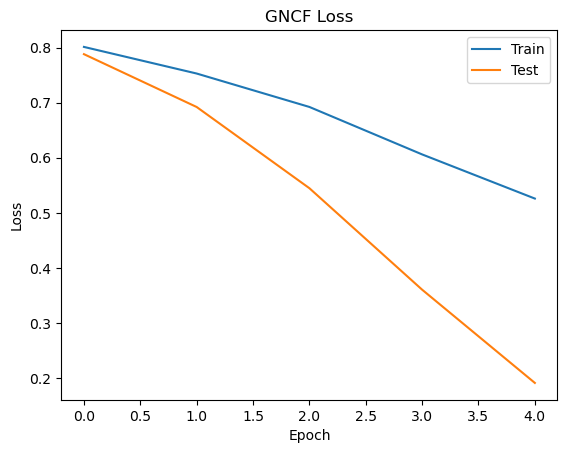

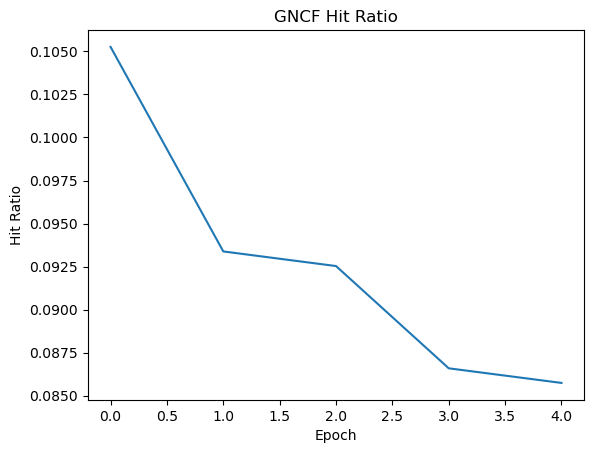

In [30]:
with open(f'runs/{save_path}/data.pkl', 'rb') as f:
    data = pickle.load(f)
    model = data['model']
    test_losses = data['test_losses']
    hit_ratios = data['hit_ratios']
    train_losses = data['train_losses']

plt.figure()
plt.plot(train_losses)
plt.plot(test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GNCF Loss')
plt.legend(['Train', 'Test'])
plt.savefig(f'runs/{save_path}/losses.png')

plt.figure()
plt.plot(hit_ratios)
plt.xlabel('Epoch')
plt.ylabel('Hit Ratio')
plt.title('GNCF Hit Ratio')
plt.savefig(f'runs/{save_path}/hit_ratios.png')
